In [1]:
import sys
print(sys.executable)
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
import os
from time import time
import pandas as pd
from glob import glob
from KerasOCRTrainer2 import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers, optimizers
from tensorflow import keras
from tensorflow.keras.layers import Lambda
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import cv2
from PIL import Image
from random import shuffle

/home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/bin/python3.6


/home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int1

/home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/bin/python3.6


In [2]:
# tf.test.is_gpu_available()

# Create df to flow from

In [3]:
# ubuntu
file_list_2 = glob('/home/eduard/workspace/VitmoOCR/data/data2/*/*.png')
# shuffle(file_list_2)
file_list_4 = glob('/home/eduard/workspace/VitmoOCR/data/data4/*/*.png')
# shuffle(file_list_4)
file_list_5 = glob('/home/eduard/workspace/VitmoOCR/data/data5/*/*.png')
# shuffle(file_list_5)
file_list_6 = glob('/home/eduard/workspace/VitmoOCR/data/data6/*/*.png')
# shuffle(file_list_6)
file_list_7 = glob('/home/eduard/workspace/VitmoOCR/data/data7/*/*.png')
# shuffle(file_list_7)
file_list_t = glob('/home/eduard/workspace/VitmoOCR/data/training_data/*/*.jpg')
# shuffle(file_list_t)

file_list = file_list_2+file_list_4+file_list_5+file_list_6+file_list_7
shuffle(file_list)
# mac
# file_list = glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/data2/*/*.png')
# file_list = file_list+glob('/Users/eduard/workspaces/ml_projects/keras/VitmoOCR/training_data/numbers_96/*/*.jpg')
df_lst = []
for file_path in file_list:
    label = file_path.split('/')[-2]
    alt_label = label
    while len(alt_label)<3:
        alt_label = ' '+alt_label
    if alt_label == 'nan':
        alt_label = '   '
        
    l0,l1,l2 = alt_label
    
    df_lst.append({
        'file_path': file_path,
        'single_label':label,
        'multi_label':np.array([l0,l1,l2]),
        'l0':str(l0),
        'l1':str(l1),
        'l2':str(l2),
#         'splitable':f'{l0},{l1},{l2}'
    }
    )
df = pd.DataFrame(df_lst)
print(df.shape)

(708004, 6)


In [4]:
df.head()

,file_path,single_label,multi_label,l0,l1,l2
0,/home/eduard/workspace/VitmoOCR/data/data2/220...,220,"[2, 2, 0]",2,2,0
1,/home/eduard/workspace/VitmoOCR/data/data2/31/...,31,"[ , 3, 1]",,3,1
2,/home/eduard/workspace/VitmoOCR/data/data6/152...,152,"[1, 5, 2]",1,5,2
3,/home/eduard/workspace/VitmoOCR/data/data4/152...,152,"[1, 5, 2]",1,5,2
4,/home/eduard/workspace/VitmoOCR/data/data6/129...,129,"[1, 2, 9]",1,2,9


In [5]:
def one_hot(cat):
    categories = [' ','0','1','2','3','4','5','6','7','8','9']
    return (cat==np.array(categories) ).astype(int).tolist()

categories = [' ','0','1','2','3','4','5','6','7','8','9']
for col in ['l0','l1','l2']:
    df[col+'d'] = df[col].apply(one_hot)
df.head()

,file_path,single_label,multi_label,l0,l1,l2,l0d,l1d,l2d
0,/home/eduard/workspace/VitmoOCR/data/data2/220...,220,"[2, 2, 0]",2,2,0,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,/home/eduard/workspace/VitmoOCR/data/data2/31/...,31,"[ , 3, 1]",,3,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]","[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]"
2,/home/eduard/workspace/VitmoOCR/data/data6/152...,152,"[1, 5, 2]",1,5,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
3,/home/eduard/workspace/VitmoOCR/data/data4/152...,152,"[1, 5, 2]",1,5,2,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
4,/home/eduard/workspace/VitmoOCR/data/data6/129...,129,"[1, 2, 9]",1,2,9,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]"


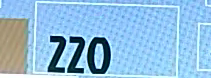

In [6]:
def random_perspective(img):
#     if np.random.randint(3)!=0:
#         pass
#     else:
#         img= np.rot90(img)
    
    
    # only apply to every n_th image
    if np.random.randint(3)!=0:
        return img
    MAX_CHANGE = 0.2
    a = np.random.rand(8).reshape(4,2)
    width, height = img.shape[:2]
    scale_factor = min(width,height)
    a = a*scale_factor*MAX_CHANGE
    pts1 = np.float32([
        [0,0],
        [width,0],
        [width,height],
        [0,height]
    ])
    pts2 = np.float32([
        [0+a[0,0],0+a[0,1]],
        [width-a[1,0],0+a[1,1]],
        [width-a[2,0],height-a[2,1]],
        [0+a[3,0],height-a[3,1]]
    ])
    M = cv2.getPerspectiveTransform(pts1,pts2)
    img = cv2.warpPerspective(img, M, (height,width))
    
    return img

path = file_list[0]
img = cv2.imread(path)
img = random_perspective(img)

Image.fromarray(img)

## Option 2

In [7]:
im_size = 48
ks = 5

mini_df = df

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.1,
    horizontal_flip=False,
    validation_split=0.1,
    preprocessing_function = random_perspective
)

y_col = ['l0d','l1d','l2d']
class_mode = 'multi_output'

train_generator = train_datagen.flow_from_dataframe(
    mini_df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="training", classes=categories,
    batch_size=128, seed=42)

valid_generator = train_datagen.flow_from_dataframe(
    mini_df, directory='/', x_col='file_path', y_col=y_col,
    target_size=(im_size, im_size), color_mode='rgb', class_mode=class_mode, 
    subset="validation", classes=categories,
    batch_size=128, seed=42)

/home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/lib/python3.6/site-packages/keras_preprocessing/image/dataframe_iterator.py:211: UserWarning: `classes` will be ignored given the class_mode="multi_output"
  .format(self.class_mode))


Found 637204 validated image filenames.
Found 70800 validated image filenames.


### Define model

In [8]:
# kernale size
ks = 5
# number of filters
nf = 32
input_img = Input(shape=(im_size, im_size, 3))
# gs_img = Lambda(lambda c: tf.image.rgb_to_grayscale(c))(input_img)
conv1 = Conv2D(nf, (ks, ks), strides=2, padding='same', activation='relu')(input_img)
drop1 = Dropout(0.05)(conv1)
conv2 = Conv2D(nf, (ks, ks), strides=2, padding='same', activation='relu')(drop1)
drop2 = Dropout(0.05)(conv2)
conv3 = Conv2D(nf, (ks, ks), strides=2, padding='same', activation='relu')(drop2)
flat1  = Flatten()(conv3)
dense1 = Dense(256,activation='relu')(flat1)
num1 = Dense(11,activation='softmax',name='num1')(dense1)
num2 = Dense(11,activation='softmax',name='num2')(dense1)
num3 = Dense(11,activation='softmax',name='num3')(dense1)

# output = keras.layers.concatenate([num1,num2,num3])
# output = [num1,num2,num3]?
model = Model(inputs = input_img, outputs=[num1,num2,num3])
model

W0910 19:57:55.920607 140032803348608 deprecation.py:506] From /home/eduard/.pyenv/versions/3.6.8/envs/keras_gpu_36/lib/python3.6/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [9]:
keras.utils.plot_model(model, 'multi_input_and_output_model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 48, 48, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 24, 24, 32)   2432        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 24, 24, 32)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 12, 12, 32)   25632       dropout[0][0]                    
______________________________________________________________________________________________

In [11]:
model_name = 'dragon64_mini_3cl32_dense256'
tensorboard = TensorBoard(log_dir=f'logs/{model_name}')
model_path = 'models/dragon_w_dense'
all_checkpoint_path = f'{model_path}''/ep{epoch:02d}-va{val_loss:.2f}.hdf5'
save_all_callback = ModelCheckpoint(
        all_checkpoint_path, 
        monitor='val_loss',
        save_best_only=False,
    )

In [12]:
model.compile(optimizers.Adam(lr=0.001),loss=["categorical_crossentropy"]*3,metrics=["accuracy"],)

In [13]:
tf.test.is_gpu_available()

True

In [ ]:
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
# STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
model.fit_generator(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=60,
                    callbacks = [tensorboard, save_all_callback]
)

Epoch 1/60
4977/4978 [============================>.] - ETA: 0s - loss: 1.8201 - num1_loss: 0.1969 - num2_loss: 0.7976 - num3_loss: 0.8256 - num1_acc: 0.9225 - num2_acc: 0.7331 - num3_acc: 0.7236

In [ ]:
! ls